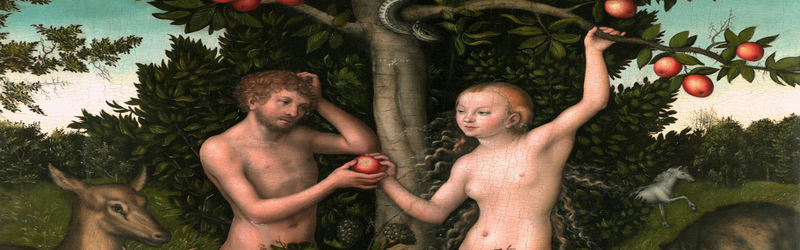
# The Decision Tree
Decision trees are perhaps one of the most venerable techniques used in machine learning, notably the [ID3](https://link.springer.com/content/pdf/10.1007/BF00116251.pdf) (published in 1986) and **C4.5** (published in 1993) algorithms  by [Ross Quinlan](https://en.wikipedia.org/wiki/Ross_Quinlan). The algorithm operates in a [greedy](https://en.wikipedia.org/wiki/Greedy_algorithm) top-down  recursive fashion.
One of the positive aspects of decision trees is their interpretability. Another attractive aspect is that they require very little pre-processing of the input data. A disadvantage of decision trees is that, since they are greedy, they can be overly sensitive to very small variations in the input training data.

# A simple example:
For this example we shall use data from the kaggle [Titanic competition](https://www.kaggle.com/c/titanic). We shall use only two of the features: `Sex` (either male or female, which we treat as [dummy variables](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)) and `Pclass`, the passenger class, which adopts the values: 1 = 1st class, 2 = 2nd class, and 3 = 3rd class (hence the title of this notebook).
We shall be making use of the scikit-learn [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [1]:
#===========================================================================
# import the libraries
#===========================================================================
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

#===========================================================================
# read in the data
#===========================================================================
train_data = pd.read_csv('../input/titanic/train.csv')
test_data  = pd.read_csv('../input/titanic/test.csv')

#===========================================================================
# features: Sex, and a bit of class...
#===========================================================================
features = ["Sex", "Pclass"]

#===========================================================================
# for the features that are categorical we use pd.get_dummies
#===========================================================================
X_train       = pd.get_dummies(train_data[features])
y_train       = train_data["Survived"]
X_test        = pd.get_dummies(test_data[features])

#===========================================================================
# perform the classification using a decision tree 
#===========================================================================
from sklearn import tree
classifier = tree.DecisionTreeClassifier(criterion='gini',
                                         splitter='best',
                                         max_depth=2,
                                         random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

# Plot the decision tree
Now let us take a look at the decisions that were made in producing our tree by [exporting the decision tree in DOT format](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html) and then using the visualization software [graphviz](http://https://graphviz.org/) to draw the tree.

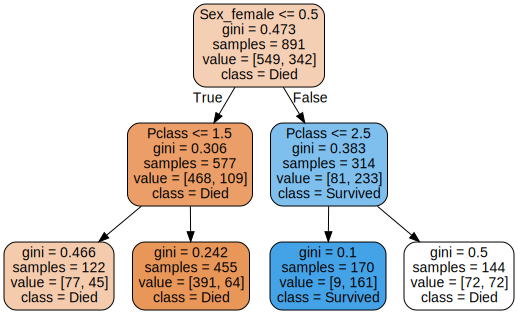

In [2]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(classifier, 
                           feature_names=X_train.columns, 
                           class_names=['Died', 'Survived'], 
                           filled=True, 
                           rounded=True,
                           proportion=False)
graphviz.Source(dot_data)

# Interpretation
At the top of the graph, the *root node*, a condition is framed whose answer is either `True` or `False`. The condition in the root node is the most influential, or ***best split*** in the tree, which is calculated using an impurity measure (here `gini`). Here the root node divides by `Sex`
In this case we now have two test, or *internal nodes*, which divides by `Pcalss`.
Finally in this example, where the stopping criteria is `max_depth=2`, we end up with four terminal decision or *leaf nodes*, or simply *leaves*, this is where the classification takes place.

In this example the root node splits the 891 samples (i.e. passengers) contained in the training data according to `Sex`; the 577 males to the left (True) and the 314 females to the right (False). 
The next two internal nodes split according to `Pclass`. 
Finally, the leftmost leaf contains males that were in 1st class (122), the next leaf contains males that were either in 2nd or 3rd class (455). The third leaf, the only leaf classifies as *Survived*, consists of females who were either in 1st or 2nd class (170). The final rightmost leaf contains the 144 females who were in the 3rd class. 

**In summary, in this simple decision tree everyone dies except females who were in either 1st or 2nd class. This is now our model.**

# What is gini?
We can see that each node and leaf has a `gini` value. This is the *gini impurity* ($I_G$) splitting criteria, which is given by

$$ I_G(p) = 1 - \sum_{i=1}^J p_i^2 $$

where $p_i$ is the fraction of samples in class $i$. In this case we have

$$ I_G = 1 - p( \mathrm{True} )^2 - p( \mathrm{False} )^2 $$

For example, in the root node we see `gini = 0.473`:

$$ I_G = 1 - \left( \frac{549}{891} \right)^2 - \left( \frac{342}{891} \right)^2 = 0.473 $$

The root node is the class that has the lowest gini impurity, i.e. leads to the best separation of classes, in this case Sex.

# Shannon information entropy
Another impurity criteria is the [Shannon information entropy](http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) ($I_E$), which is implemented with the flag `entropy` and is given by

$$ I_E(p) =  - \sum_{i=1}^J p_i \log_2 (p_i) $$

which for the root node would be

$$ I_E(p) = - \left( \frac{549}{891} \right) \log_2  \left( \frac{549}{891} \right)  - \left( \frac{342}{891} \right) \log_2 \left( \frac{342}{891} \right)  = 0.961 $$

For example:

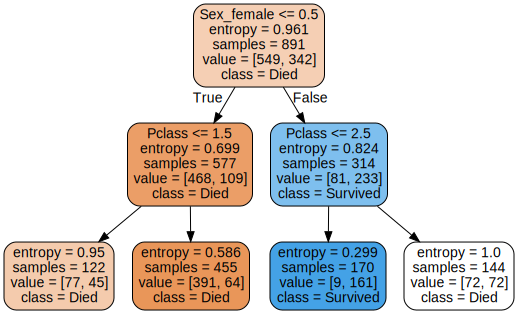

In [3]:
classifier = tree.DecisionTreeClassifier(criterion='entropy',
                                         splitter='best',
                                         max_depth=2,
                                         random_state=42)
classifier.fit(X_train, y_train)

# now visualise the 'entropy' tree
dot_data = export_graphviz(classifier, 
                           feature_names=X_train.columns, 
                           class_names=['Died', 'Survived'], 
                           filled=True, 
                           rounded=True,
                           proportion=False)
graphviz.Source(dot_data)

we can see that in this instance the results are exactly the same as those obtained with the *gini impurity*.
What do these two impurity functions look like? We shall make a plot

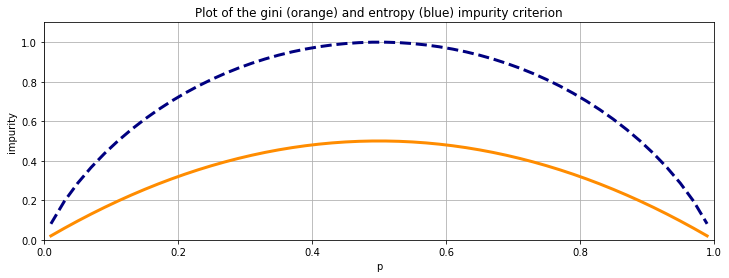

In [4]:
plt.figure(figsize = (12,4))
limit = 1
x = np.linspace(0.01, limit-0.01, 50)
line_1 = 1 - (x**2) - (1-x)**2
line_2 = ( -1*x*np.log2(x) ) - ( (1-x)*np.log2(1-x) )
#------------------------------------------
plt.plot(x,line_1, color='darkorange', linestyle='solid', lw=3)
plt.plot(x,line_2, color='navy',       linestyle='dashed', lw=3)
#------------------------------------------
plt.title   ("Plot of the gini (orange) and entropy (blue) impurity criterion")
plt.xlabel  ("p")
plt.ylabel  ("impurity")
#------------------------------------------
plt.xlim    (0, limit)
plt.ylim    (0, limit+0.1)
#------------------------------------------
plt.grid(True)
#------------------------------------------
plt.show()

## Which is best, gini or entropy?
As we have seen above, both splitting criteria result in the same tree, and indeed, there is no general consensus as to which is the best. In the paper ["Theoretical Comparison between the Gini Index and Information Gain Criteria"](https://doi.org/10.1023/B:AMAI.0000018580.96245.c6) by Raileanu and Stoffel they summarize by saying: 
> "*...they disagree only in 2% of all cases, which
explains why most previously published empirical results concluded that it is not possible
to decide which one of the two tests performs better.*"

# Score the model
We now proceed to apply our above model obtained from the training data `X_train` and `y_train`, which was 

> *Everyone dies except females who were in either 1st or 2nd class.*

to the test data, `X_test`, and submit it to the competition:

In [5]:
# first fill an array with zeros (i.e. initially there are no survivors at all)
predictions = np.zeros((418), dtype=int)

# now use our model
survived_df = X_test[((X_test["Pclass"] ==1)|(X_test["Pclass"] ==2)) & (X_test["Sex_female"]==1 )]

for i in survived_df.index:
    predictions[i] = 1 # the 1's are now the survivors
    
#===========================================================================
# write out CSV submission file
#===========================================================================
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

The final score is given at the very top of this notebook: we can see that this extremely simple and highly interpretable model is **77.5% accurate**.
# Further reading
* [Decision Trees](https://scikit-learn.org/stable/modules/tree.html) on Scikit-learn
* [Decision tree learning](https://en.wikipedia.org/wiki/Decision_tree_learning) on Wikipedia
* [Lior Rokach and Oded Maimon "Decision Trees" in 'Data Mining and Knowledge Discovery Handbook' Chapter 9 pp 165-192 (2005)](https://doi.org/10.1007/0-387-25465-X_9)
* [S. B. Kotsiantis "Decision trees: A recent overview",  Artif. Intell. Rev. **39** pp. 261-283 (2013). ](https://doi.org/10.1007/s10462-011-9272-4)

# Related notebooks
I am far from the first person on kaggle to apply a decision tree classifier to the Titanic dataset or otherwise, and here are links to some notebooks that are well worth taking a look at:
* [Introduction to Decision Trees (Titanic dataset)](https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset) by [Diego Milla](https://www.kaggle.com/dmilla)
* [Playing with the knobs of sklearn decision tree](https://www.kaggle.com/drgilermo/playing-with-the-knobs-of-sklearn-decision-tree) by [Omri Goldstein](https://www.kaggle.com/drgilermo)
* [Decision-Tree Classifier Tutorial ](https://www.kaggle.com/prashant111/decision-tree-classifier-tutorial) by [Prashant Banerjee](https://www.kaggle.com/prashant111)
* ...and *many* more...